In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('NEAT_logged_data copy.csv')

In [36]:
# time per lap
lap_time_group = df.groupby(df['attempt_id'])['step'].max() / 50
print(lap_time_group.to_string(index=True))

attempt_id
0     12.72
1     12.66
2     12.50
3     12.90
4     12.86
5     12.72
6     12.42
7     12.34
8     12.56
9     12.66
10    12.58


In [6]:
# Define sensor columns
sensor_columns = [f'sensor{i}' for i in range(15)]

# Calculate line position based on active sensors
def calculate_line_position(row):
    active_sensors = [i for i, col in enumerate(sensor_columns) if row[col] == 1]
    return np.mean(active_sensors) if active_sensors else np.nan

df['line_position'] = df.apply(calculate_line_position, axis=1)

# Forward fill missing positions within each attempt
df['line_position'] = df.groupby('attempt_id')['line_position'].ffill()

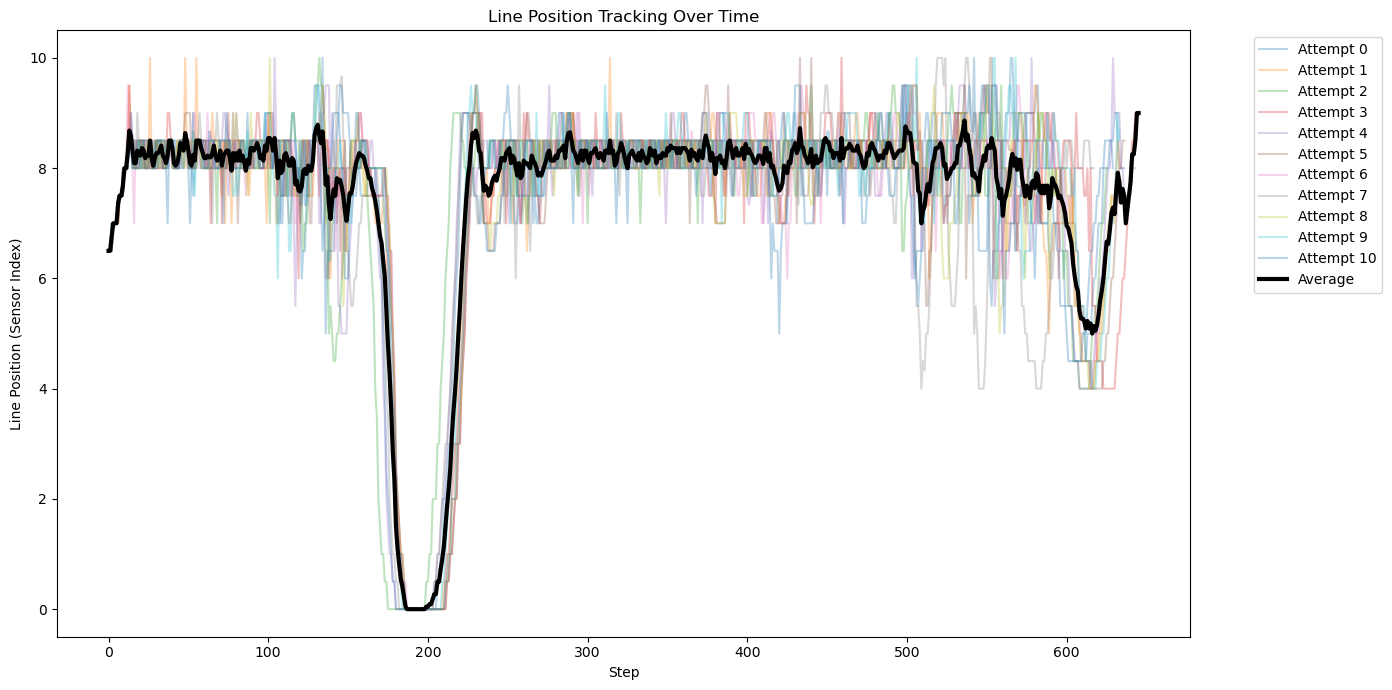

In [39]:
# Time Series Visualization
plt.figure(figsize=(14, 7))
attempt_ids = df['attempt_id'].unique()

# Plot individual attempts
for attempt_id in attempt_ids:
    attempt_data = df[df['attempt_id'] == attempt_id]
    plt.plot(attempt_data['step'], attempt_data['line_position'], 
             alpha=0.3, label=f'Attempt {attempt_id}')

# Calculate and plot average line position
average_line = df.groupby('step')['line_position'].mean()
plt.plot(average_line.index, average_line.values, 
         color='black', linewidth=3, label='Average')

plt.title('Line Position Tracking Over Time')
plt.xlabel('Step')
plt.ylabel('Line Position (Sensor Index)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

C:\Users\Pc\AppData\Local\Temp\ipykernel_6924\1555536464.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sensor_counts.index, y=sensor_counts.values, palette='viridis')


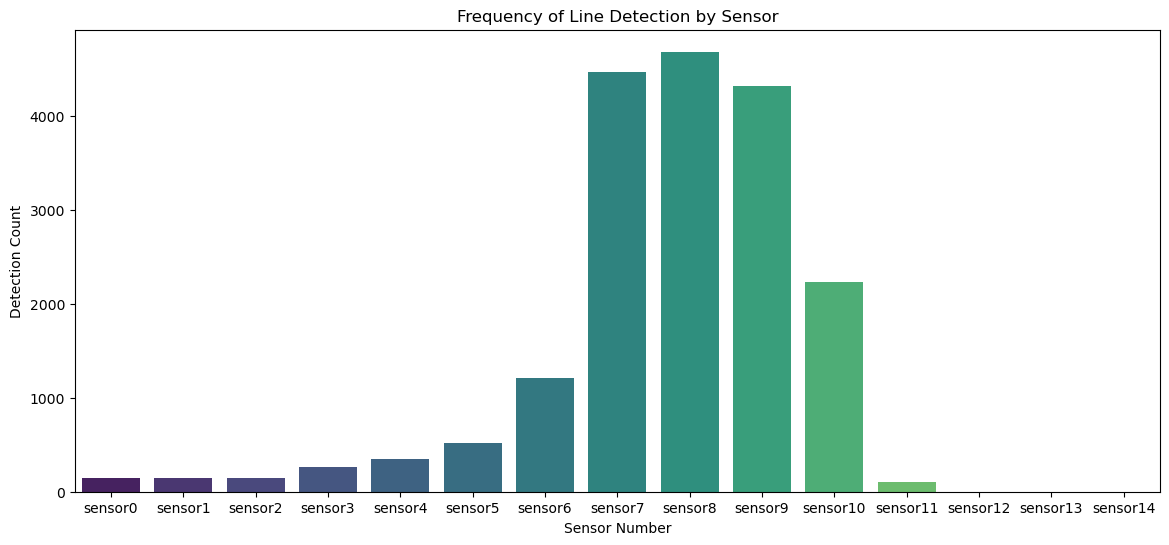

In [8]:
# Sensor Frequency Bar Chart
plt.figure(figsize=(14, 6))
sensor_counts = df[sensor_columns].sum()#.sort_values(ascending=False)
sns.barplot(x=sensor_counts.index, y=sensor_counts.values, palette='viridis')
plt.title('Frequency of Line Detection by Sensor')
plt.xlabel('Sensor Number')
plt.ylabel('Detection Count')
plt.show()

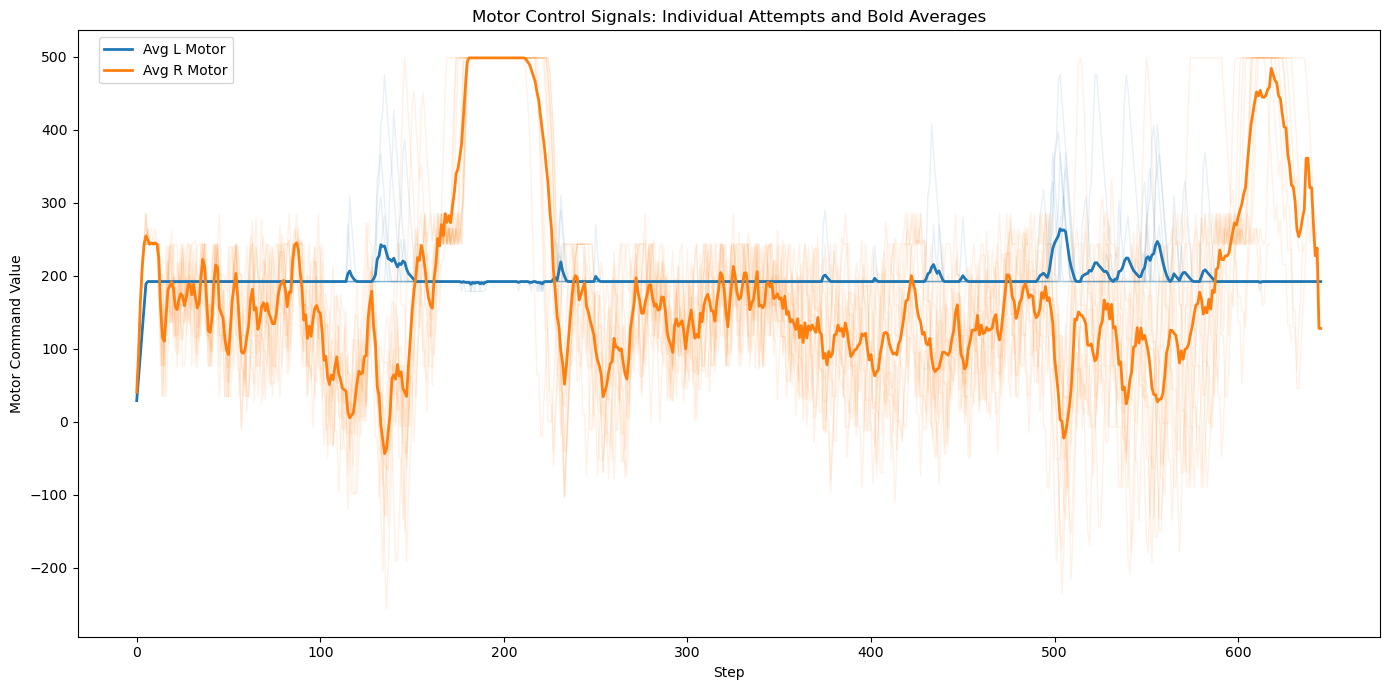

In [70]:
# Plot individual attempts with distinct colors and overlay the bold average lines

plt.figure(figsize=(14, 7))
# Get a color palette with as many colors as unique attempts
unique_attempts = np.sort(df['attempt_id'].unique())
colors = sns.color_palette("tab10", len(unique_attempts))

# Plot each attempt (using average per step for each attempt) with fixed colors for left and right
for att in unique_attempts:
    attempt_df = df[df['attempt_id'] == att].groupby('step')[['action_L', 'action_R']].mean()
    plt.plot(attempt_df.index, attempt_df['action_L'], color='C0', lw=1, alpha=0.1)
    plt.plot(attempt_df.index, attempt_df['action_R'], color='C1', lw=1, alpha=0.1)

# Compute overall average actions per step (if not already computed)
avg_actions = df.groupby('step')[['action_L', 'action_R']].mean()

# Overlay the average actions in bold using the same fixed colors
plt.plot(avg_actions.index, avg_actions['action_L'], color='C0', lw=2, label='Avg L Motor', linestyle='-')
plt.plot(avg_actions.index, avg_actions['action_R'], color='C1', lw=2, label='Avg R Motor', linestyle='-')

plt.title('Motor Control Signals: Individual Attempts and Bold Averages')
plt.xlabel('Step')
plt.ylabel('Motor Command Value')
plt.legend(bbox_to_anchor=(0.125, 1))
plt.tight_layout()
plt.show()


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0, 0.5, 'sensor0'),
  Text(0, 1.5, 'sensor1'),
  Text(0, 2.5, 'sensor2'),
  Text(0, 3.5, 'sensor3'),
  Text(0, 4.5, 'sensor4'),
  Text(0, 5.5, 'sensor5'),
  Text(0, 6.5, 'sensor6'),
  Text(0, 7.5, 'sensor7'),
  Text(0, 8.5, 'sensor8'),
  Text(0, 9.5, 'sensor9'),
  Text(0, 10.5, 'sensor10'),
  Text(0, 11.5, 'sensor11'),
  Text(0, 12.5, 'sensor12'),
  Text(0, 13.5, 'sensor13'),
  Text(0, 14.5, 'sensor14')])

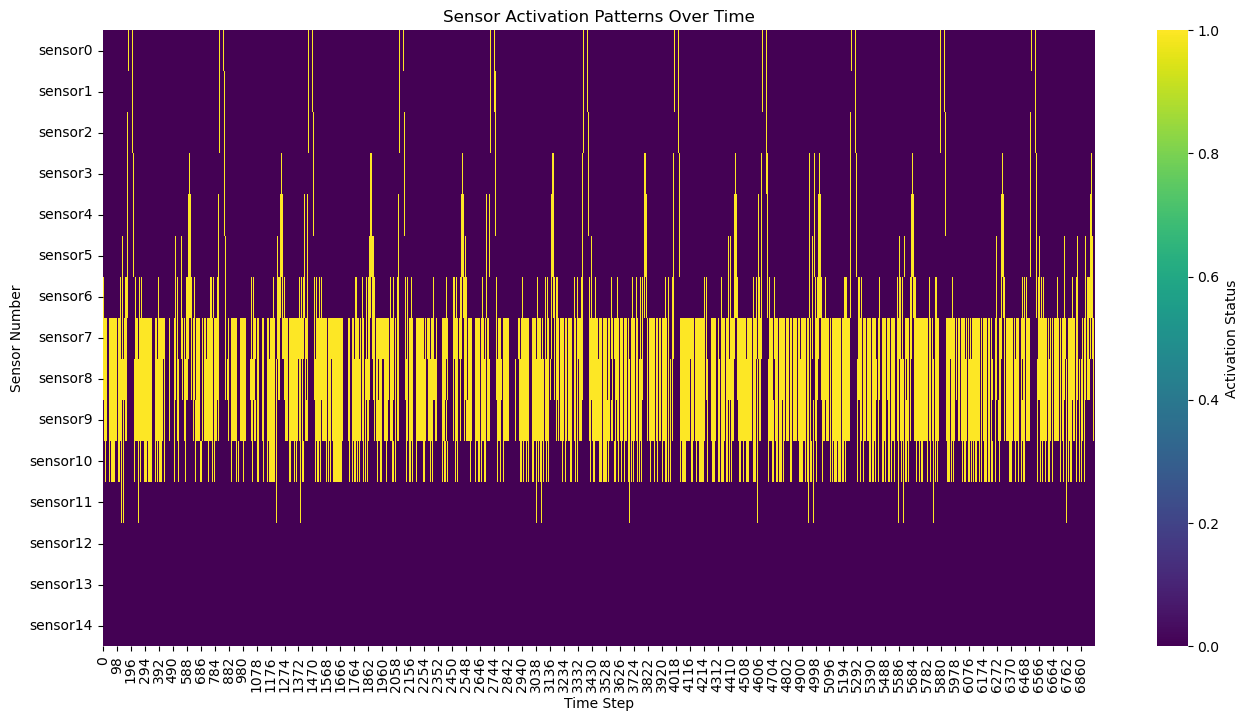

In [10]:
plt.figure(figsize=(16, 8))
sns.heatmap(df[sensor_columns].T, cmap='viridis', 
            cbar_kws={'label': 'Activation Status'})
plt.title('Sensor Activation Patterns Over Time')
plt.xlabel('Time Step')
plt.ylabel('Sensor Number')
plt.yticks(rotation=0)

C:\Users\Pc\AppData\Local\Temp\ipykernel_6924\2841333295.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=avg_deviation.index, y=avg_deviation.values, color='blue', ci=None)


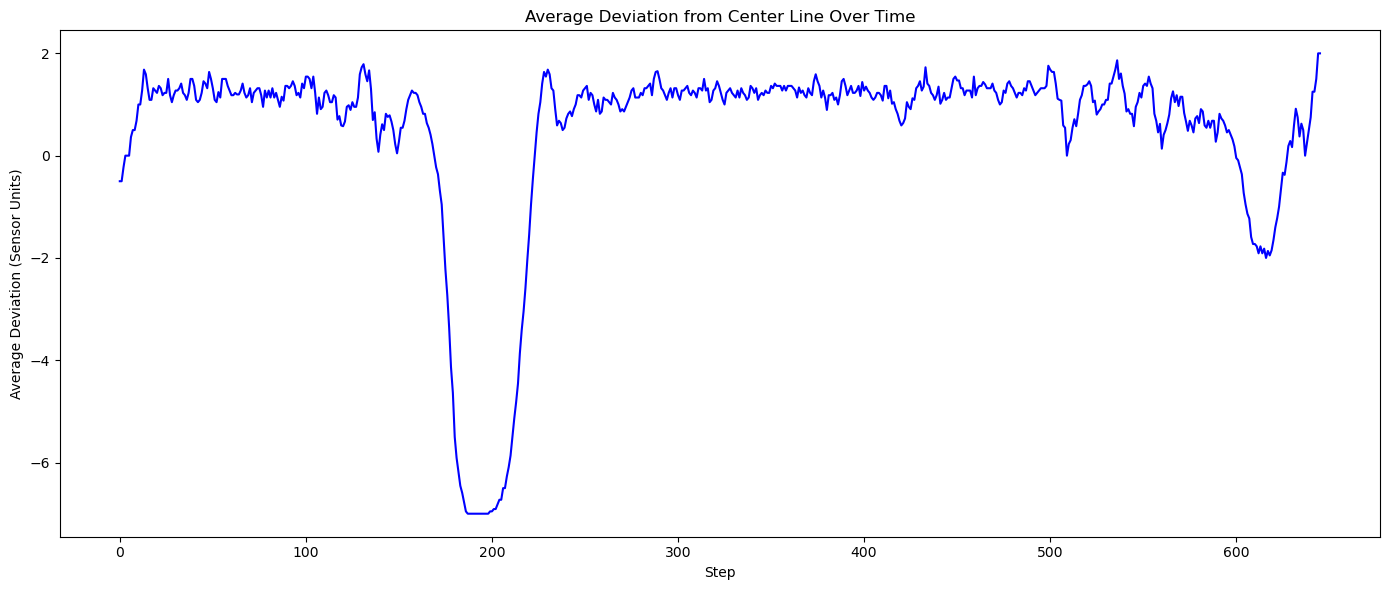

In [29]:
df['deviation'] = df['line_position'] - 7  # center is sensor 7
avg_deviation = df.groupby('step')['deviation'].mean()

plt.figure(figsize=(14, 6))
sns.lineplot(x=avg_deviation.index, y=avg_deviation.values, color='blue', ci=None)
plt.title('Average Deviation from Center Line Over Time')
plt.xlabel('Step')
plt.ylabel('Average Deviation (Sensor Units)')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Correlation Matrix of Sensors and Control Signals')

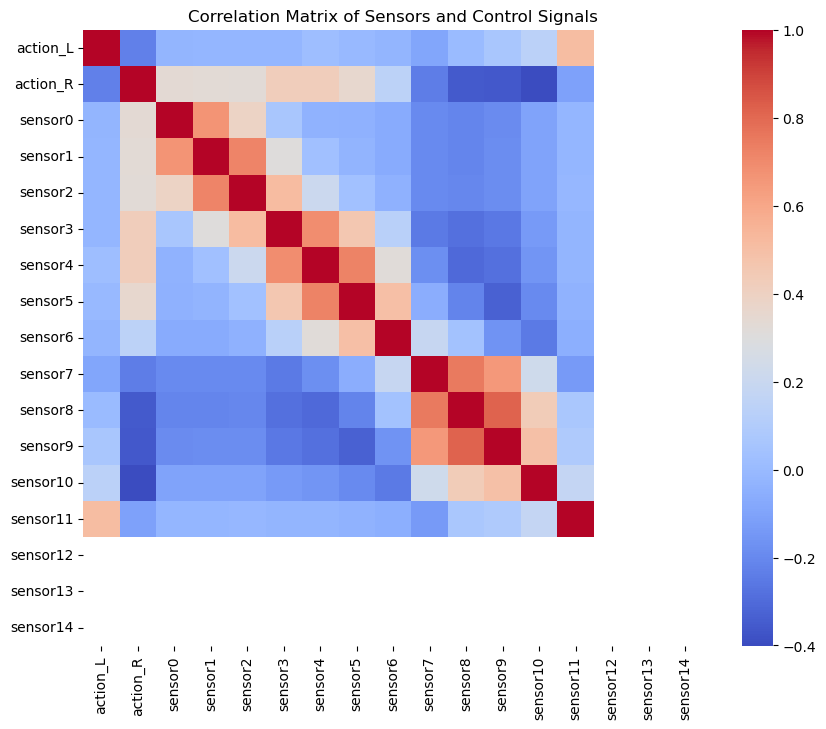

In [30]:
plt.figure(figsize=(10, 8))
corr_matrix = df[['action_L', 'action_R'] + sensor_columns].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Sensors and Control Signals')

Text(0, 0.5, 'Smoothed Line Position')

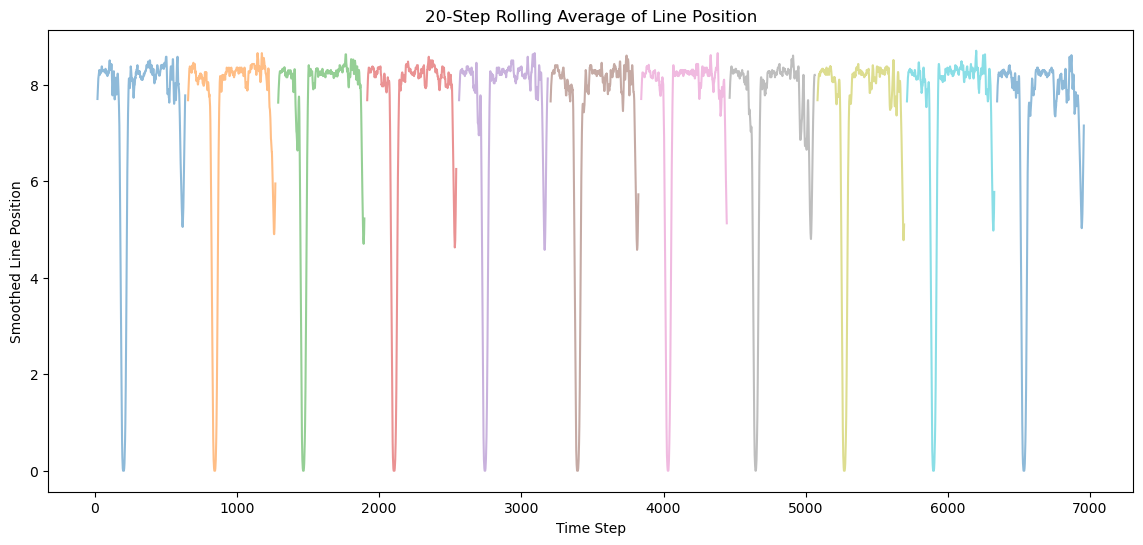

In [13]:
window_size = 20
plt.figure(figsize=(14, 6))
for attempt in df['attempt_id'].unique():
    attempt_data = df[df['attempt_id'] == attempt]
    rolling_avg = attempt_data['line_position'].rolling(window=window_size).mean()
    plt.plot(rolling_avg, alpha=0.5)

plt.title(f'{window_size}-Step Rolling Average of Line Position')
plt.xlabel('Time Step')
plt.ylabel('Smoothed Line Position')

Text(120.7222222222222, 0.5, 'Previous State')

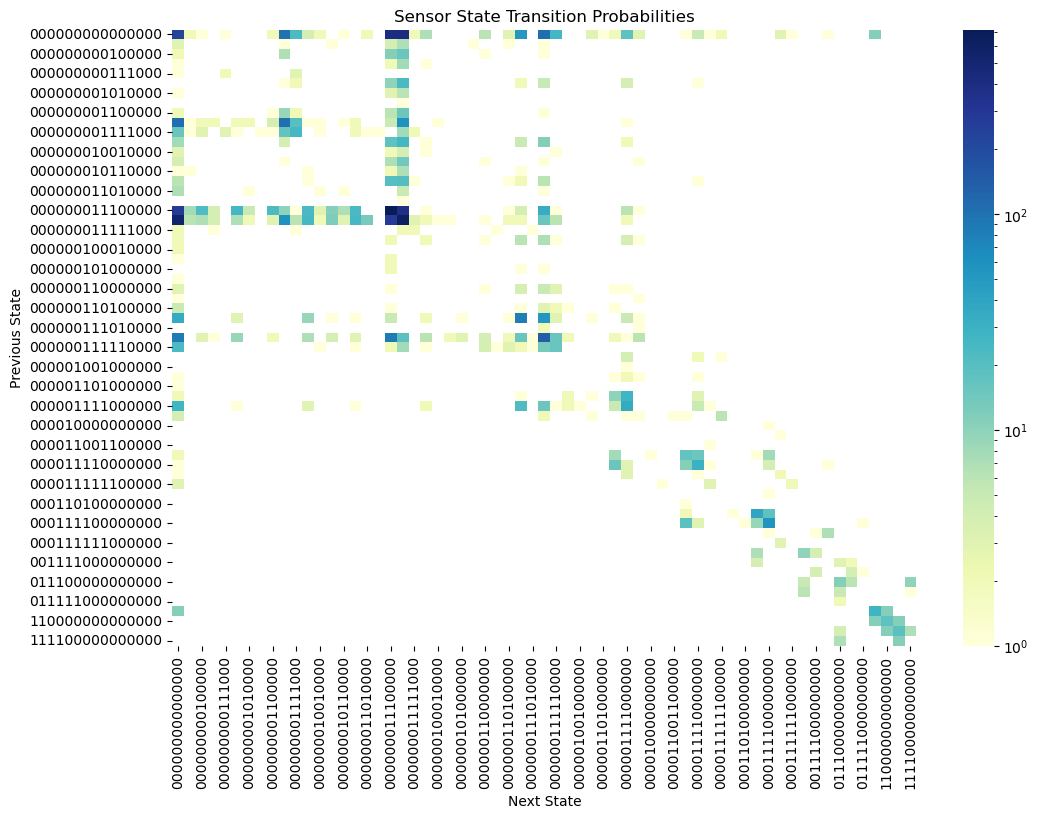

In [14]:
from matplotlib.colors import LogNorm

# Create transition matrix between sensor states
sensor_states = df[sensor_columns].astype(int).astype(str).sum(axis=1)
transitions = pd.Series(sensor_states).value_counts().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.heatmap(pd.crosstab(sensor_states.shift(), sensor_states), 
            norm=LogNorm(), cmap='YlGnBu')
plt.title('Sensor State Transition Probabilities')
plt.xlabel('Next State')
plt.ylabel('Previous State')

Text(0.5, 0, 'Attempt ID')

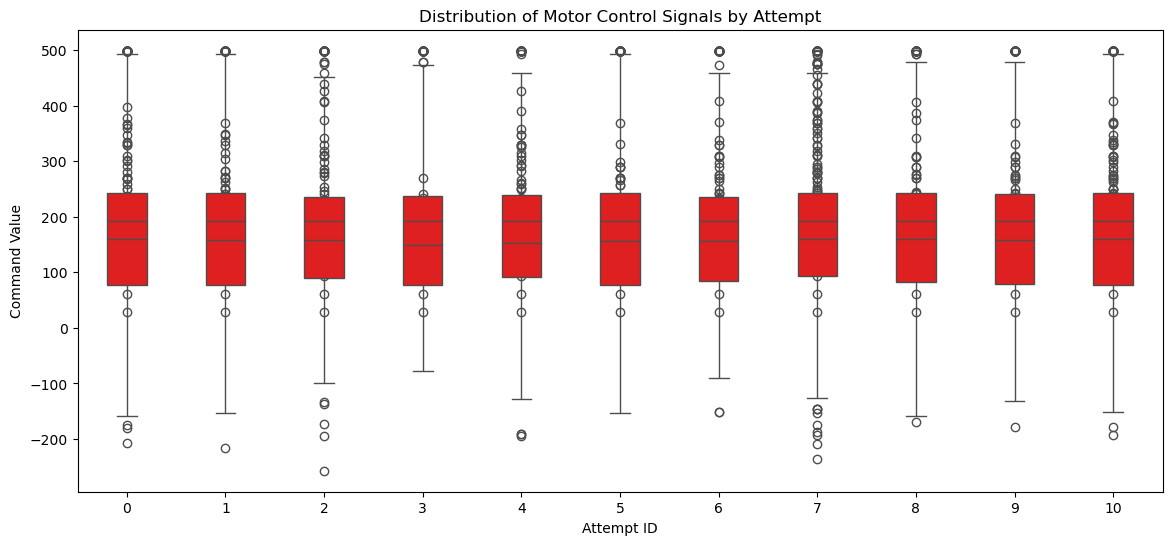

In [15]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='attempt_id', y='action_L', color='blue', width=0.4)
sns.boxplot(data=df, x='attempt_id', y='action_R', color='red', width=0.4)
plt.title('Distribution of Motor Control Signals by Attempt')
plt.ylabel('Command Value')
plt.xlabel('Attempt ID')

Text(0, 0.5, 'Lateral Position')

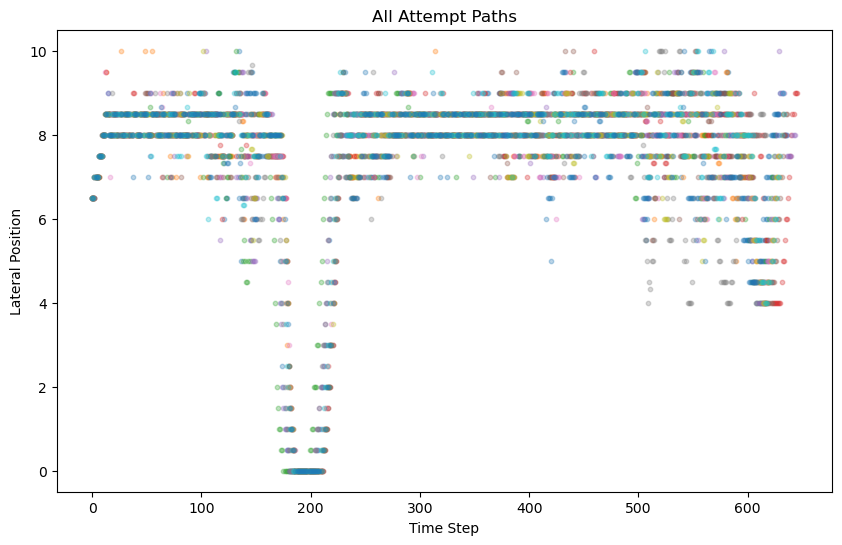

In [16]:
plt.figure(figsize=(10, 6))
for attempt in df['attempt_id'].unique():
    attempt_data = df[df['attempt_id'] == attempt]
    plt.scatter(attempt_data['step'], attempt_data['line_position'], 
                alpha=0.3, s=10)
plt.title('All Attempt Paths')
plt.xlabel('Time Step')
plt.ylabel('Lateral Position')

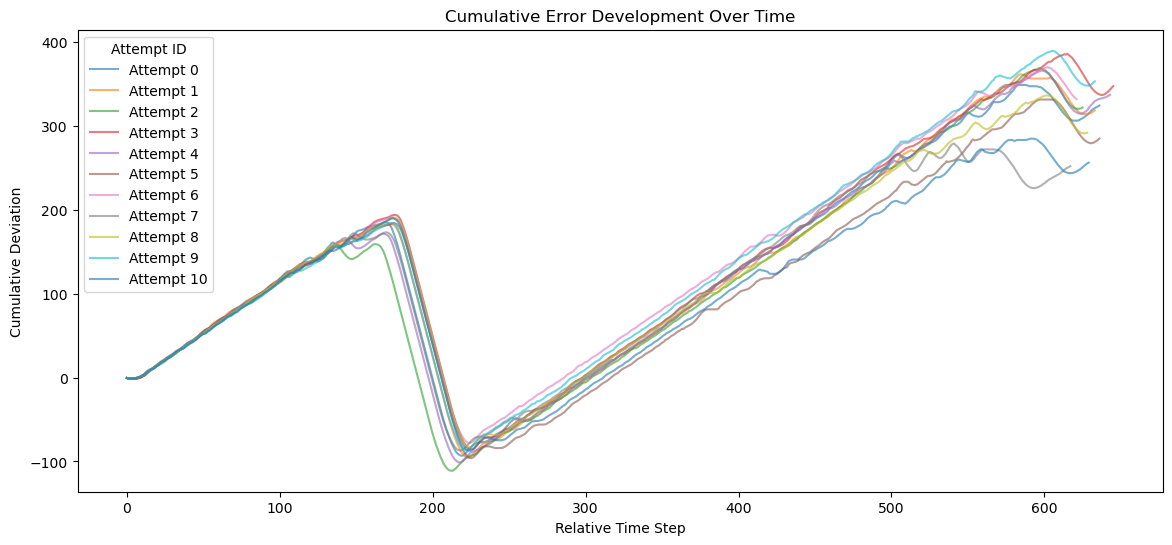

In [17]:
plt.figure(figsize=(14, 6))
for attempt in df['attempt_id'].unique():
    attempt_data = df[df['attempt_id'] == attempt].sort_values('step')
    cumulative_error = attempt_data['deviation'].cumsum()
    rel_steps = attempt_data['step'] - attempt_data['step'].iloc[0]
    plt.plot(rel_steps, cumulative_error, alpha=0.6, label=f'Attempt {attempt}')

plt.title('Cumulative Error Development Over Time')
plt.xlabel('Relative Time Step')
plt.ylabel('Cumulative Deviation')
plt.legend(title='Attempt ID')
plt.show()


In [38]:
import numpy as np
import pandas as pd

# Store results here
results = []

# Loop through attempts and compute metrics
for attempt in df['attempt_id'].unique():
    attempt_data = df[df['attempt_id'] == attempt]
    
    total_error = attempt_data['deviation'].sum()
    rmse = np.sqrt(np.mean(np.square(attempt_data['deviation'])))
    
    results.append({
        'Attempt ID': attempt,
        'Total Error': total_error,
        'RMSE': rmse
    })

# Convert to DataFrame for easier display
metrics_df = pd.DataFrame(results)

lap_time_group = df.groupby(df['attempt_id'])['step'].max() / 50

# Compute overall averages
average_total_error = metrics_df['Total Error'].mean()
average_rmse = metrics_df['RMSE'].mean()
metrics_df['lap_time'] = lap_time_group

# Display the metrics
print("Per-Attempt Error Metrics:\n")
print(metrics_df.to_string(index=False))

print("\nAverage Across All Attempts:")
print(f"Average Total Error: {average_total_error:.4f}")
print(f"Average RMSE: {average_rmse:.4f}")
print(f"Average Lap Time: {lap_time_group.mean()}")

Per-Attempt Error Metrics:

 Attempt ID  Total Error     RMSE  lap_time
          0   324.166667 2.120858     12.72
          1   318.333333 2.102004     12.66
          2   321.833333 2.111077     12.50
          3   347.333333 2.103422     12.90
          4   337.000000 2.108799     12.86
          5   284.833333 2.102645     12.72
          6   331.833333 2.075726     12.42
          7   251.916667 2.108092     12.34
          8   291.666667 2.079012     12.56
          9   353.000000 2.091849     12.66
         10   256.166667 2.072996     12.58

Average Across All Attempts:
Average Total Error: 310.7348
Average RMSE: 2.0979
Average Lap Time: 12.62909090909091


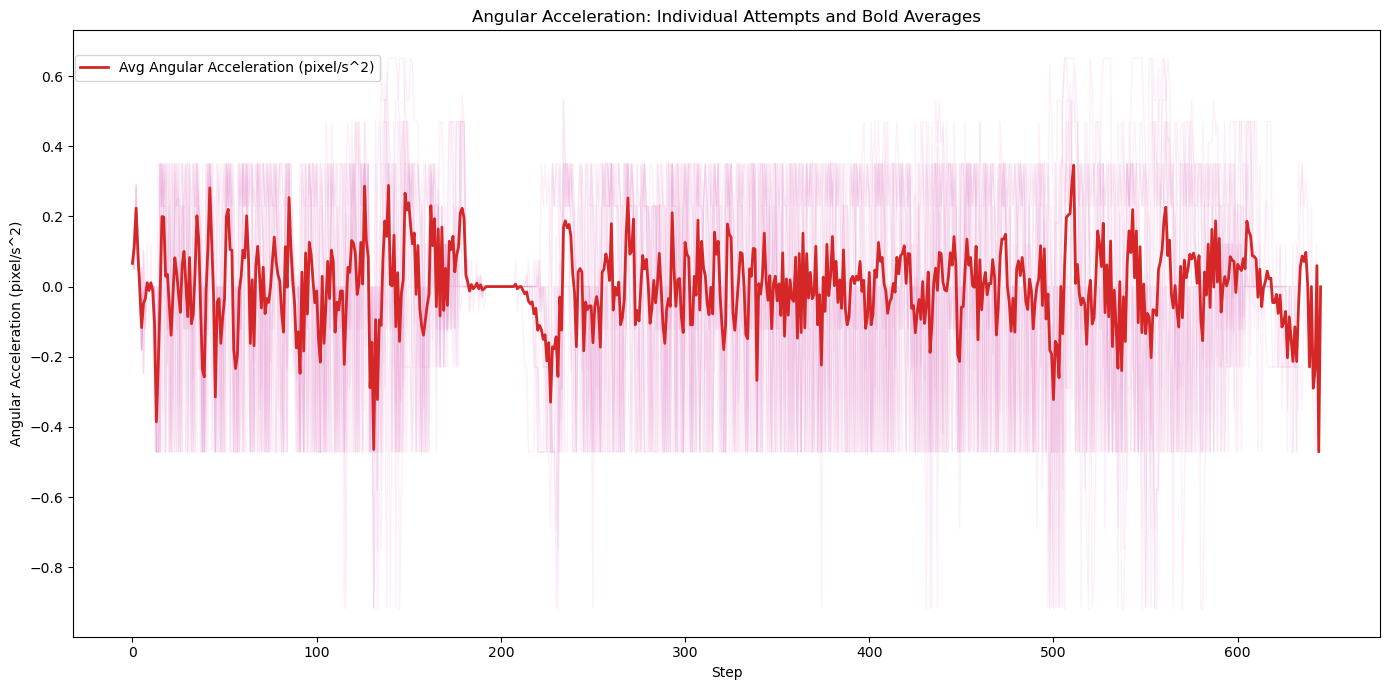

In [42]:
# Plot individual attempts with distinct colors and overlay the bold average lines

plt.figure(figsize=(14, 7))
# Get a color palette with as many colors as unique attempts
unique_attempts = np.sort(df['attempt_id'].unique())
colors = sns.color_palette("tab10", len(unique_attempts))

# Plot each attempt (using average per step for each attempt) with fixed colors for left and right
for att in unique_attempts:
    attempt_df = df[df['attempt_id'] == att].groupby('step')['angular_acceleration'].mean()
    plt.plot(attempt_df.index, attempt_df, color='C6', lw=1, alpha=0.1)

# Compute overall average actions per step (if not already computed)
avg_actions = df.groupby('step')['angular_acceleration'].mean()

# Overlay the average actions in bold using the same fixed colors
plt.plot(avg_actions.index, avg_actions, color='C03', lw=2, label='Avg Angular Acceleration (pixel/s^2)', linestyle='-')

plt.title('Angular Acceleration: Individual Attempts and Bold Averages')
plt.xlabel('Step')
plt.ylabel('Angular Acceleration (pixel/s^2)')
plt.legend(bbox_to_anchor=(0.2405, 0.97))
plt.tight_layout()
plt.show()


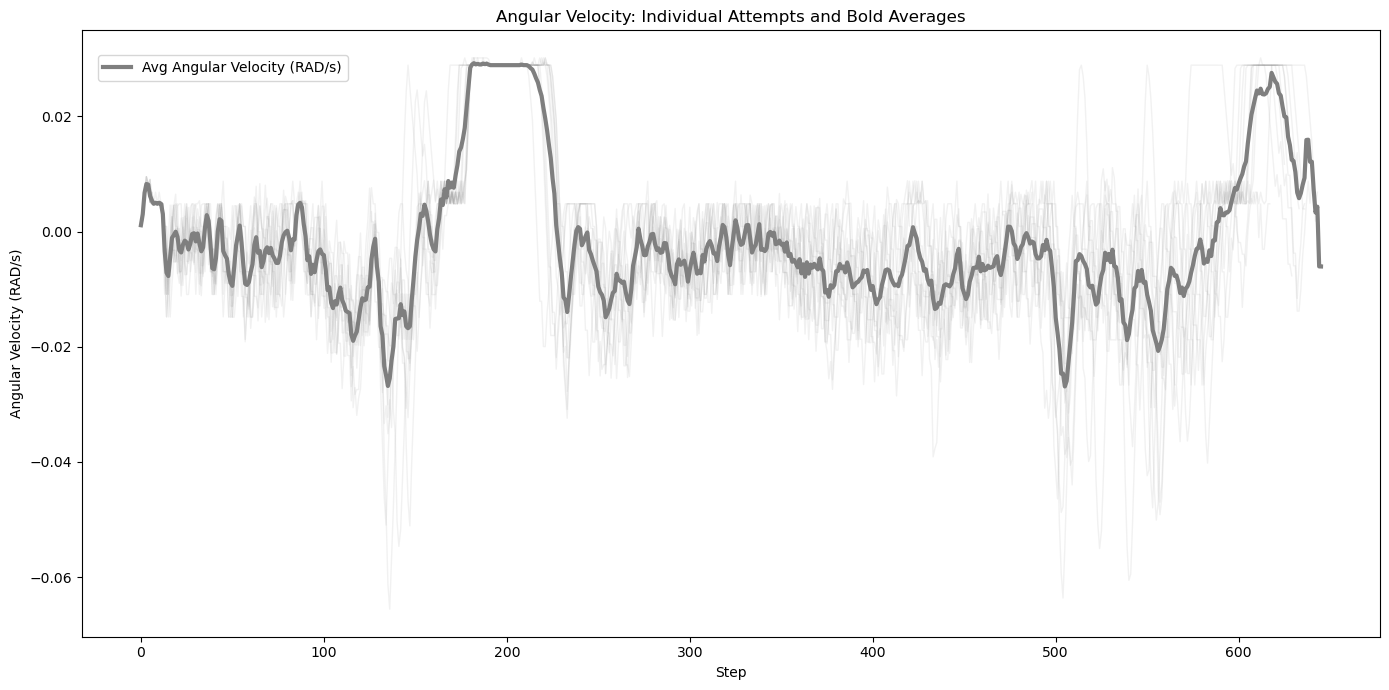

In [24]:
# Plot individual attempts with distinct colors and overlay the bold average lines

plt.figure(figsize=(14, 7))
# Get a color palette with as many colors as unique attempts
unique_attempts = np.sort(df['attempt_id'].unique())
colors = sns.color_palette("tab10", len(unique_attempts))

# Plot each attempt (using average per step for each attempt) with fixed colors for left and right
for att in unique_attempts:
    attempt_df = df[df['attempt_id'] == att].groupby('step')['angular_velocity'].mean()
    plt.plot(attempt_df.index, attempt_df, color='C7', lw=1, alpha=0.1)

# Compute overall average actions per step (if not already computed)
avg_actions = df.groupby('step')['angular_velocity'].mean()

# Overlay the average actions in bold using the same fixed colors
plt.plot(avg_actions.index, avg_actions, color='C7', lw=3, label='Avg Angular Velocity (RAD/s)', linestyle='-')

plt.title('Angular Velocity: Individual Attempts and Bold Averages')
plt.xlabel('Step')
plt.ylabel('Angular Velocity (RAD/s)')
plt.legend(bbox_to_anchor=(0.21, 0.97))
plt.tight_layout()
plt.show()
